# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Мат.часть" data-toc-modified-id="Мат.часть-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Мат.часть</a></div><div class="lev1 toc-item"><a href="#Одно-сравнение" data-toc-modified-id="Одно-сравнение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Одно сравнение</a></div><div class="lev1 toc-item"><a href="#Множественное-сравнение" data-toc-modified-id="Множественное-сравнение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Множественное сравнение</a></div>

# Мат.часть

Книга про байесовские методы:
http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/

Про A/B-тестирование байесовскими методами:
* https://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/
* http://sl8r000.github.io/ab_testing_statistics/use_a_hierarchical_model/

# Одно сравнение

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
%matplotlib inline

# Количество успехов и испытаний в первом варианте
k1 = 230
n1 = 1000

# Количество успехов и испытаний во втором варианте
k2 = 540
n2 = 2000

with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("p_B - p_A", p_B - p_A)

    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Binomial("obs_A", n1, p_A, observed=k1)
    obs_B = pm.Binomial("obs_B", n2, p_B, observed=k2)

    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -14.541: 100%|███████| 200000/200000 [00:10<00:00, 18634.12it/s]
Finished [100%]: Average ELBO = -14.525
100%|██████████████████████████████████| 10000/10000 [00:05<00:00, 1957.71it/s]


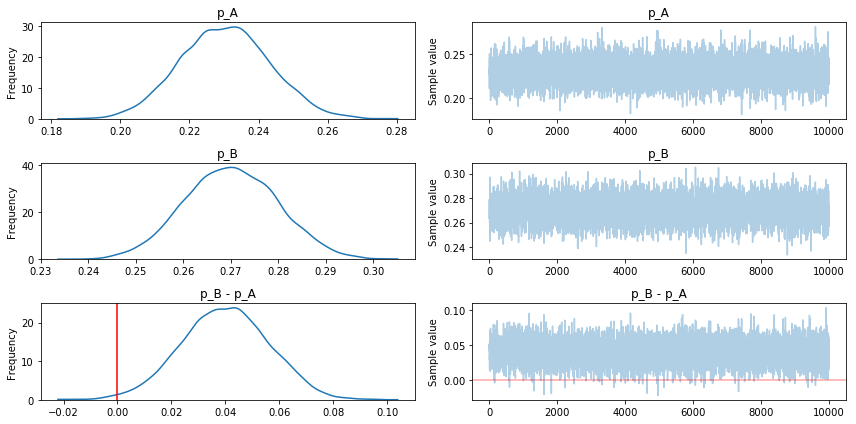

In [7]:
_ = pm.traceplot(trace, lines={'p_B - p_A':0})

In [9]:
pm.summary(trace, varnames=['p_B - p_A'])


p_B - p_A:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.040            0.016            0.000            [0.009, 0.072]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.008          0.029          0.040          0.051          0.071



In [10]:
(trace['p_B - p_A'] > 0).mean()

0.99219999999999997

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000001B83E748>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000000146DD320>], dtype=object)

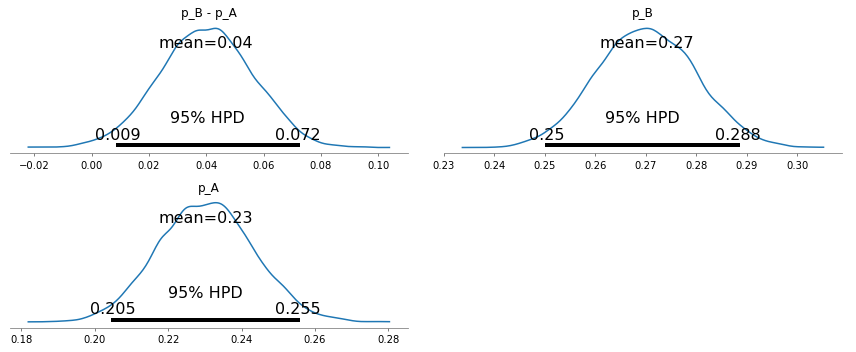

In [11]:
pm.plot_posterior(trace, kde_plot=True)

# Множественное сравнение

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
%matplotlib inline

import theano.tensor as tt
from theano import shared

successes_A =     np.array([ 502,  612,  658,  648, 419, 313,  537, 426])
trials_A = shared(np.array([1005, 1133, 1236, 1343, 781, 756, 1061, 840]))

successes_B =     np.array([471,  606,  634,  655, 373, 285, 481, 404])   
trials_B = shared(np.array([972, 1143, 1165, 1289, 742, 686, 908, 796]))

n = successes_A.shape[0]

with pm.Model() as mc_model:
    r = pm.Uniform('r', 0, 1)
    s = pm.Flat('s', testval=1)
    
    a = pm.Deterministic("a", r/(s*s))
    b = pm.Deterministic("b", (1.0-r)/(s*s))
    
    true_rates_A = pm.Beta('true_rates_A', a, b, shape=n)
    true_rates_B = pm.Beta('true_rates_B', a, b, shape=n)
    deltas = pm.Deterministic("deltas", true_rates_B - true_rates_A)
    
    obs_A = pm.Binomial('obs_A', n=trials_A, p=true_rates_A, observed=successes_A)
    obs_B = pm.Binomial('obs_B', n=trials_B, p=true_rates_B, observed=successes_B)
    
    trace = pm.sample(20000, tune=5000)

C:\tools\Anaconda\lib\site-packages\theano\tensor\basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -1.6393e+05: 100%|████| 200000/200000 [00:21<00:00, 9115.77it/s]
Finished [100%]: Average ELBO = -1.1796e+06
100%|████████████████████████████████████| 20000/20000 [04:40<00:00, 97.88it/s]


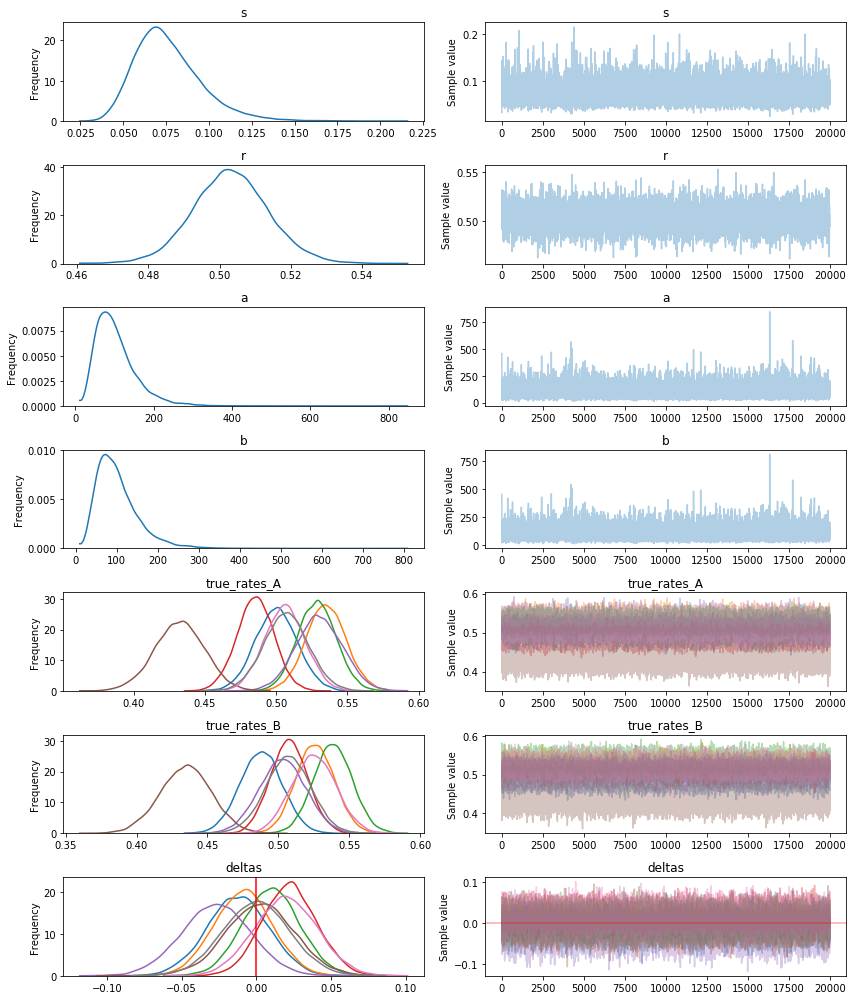

In [2]:
_ = pm.traceplot(trace, lines={'deltas':0})

Вариант с явным заданием априорного распределения гиперпараметров.

In [3]:
def hyperpriors_func(value):
    return tt.switch(tt.any(value <= 0.0),
                         -np.Inf,
                         tt.log(tt.power(value[0] + value[1], -2.5)))
# https://github.com/pymc-devs/pymc3/issues/699
    
with pm.Model() as mc_model:
    hyperpriors = pm.DensityDist('hyperpriors', hyperpriors_func, shape=2, testval=[1,1])
    
    a = hyperpriors[0]
    b = hyperpriors[1]
    
    true_rates_A = pm.Beta('true_rates_A', a, b, shape=n)
    true_rates_B = pm.Beta('true_rates_B', a, b, shape=n)
    deltas = pm.Deterministic("deltas", true_rates_B - true_rates_A)
    
    obs_A = pm.Binomial('obs_A', n=trials_A, p=true_rates_A, observed=successes_A)
    obs_B = pm.Binomial('obs_B', n=trials_B, p=true_rates_B, observed=successes_B)
    
    trace = pm.sample(20000, tune=5000)    

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -94.88: 100%|█████████| 200000/200000 [00:21<00:00, 9518.82it/s]
Finished [100%]: Average ELBO = -94.506
100%|███████████████████████████████████| 20000/20000 [00:56<00:00, 354.33it/s]


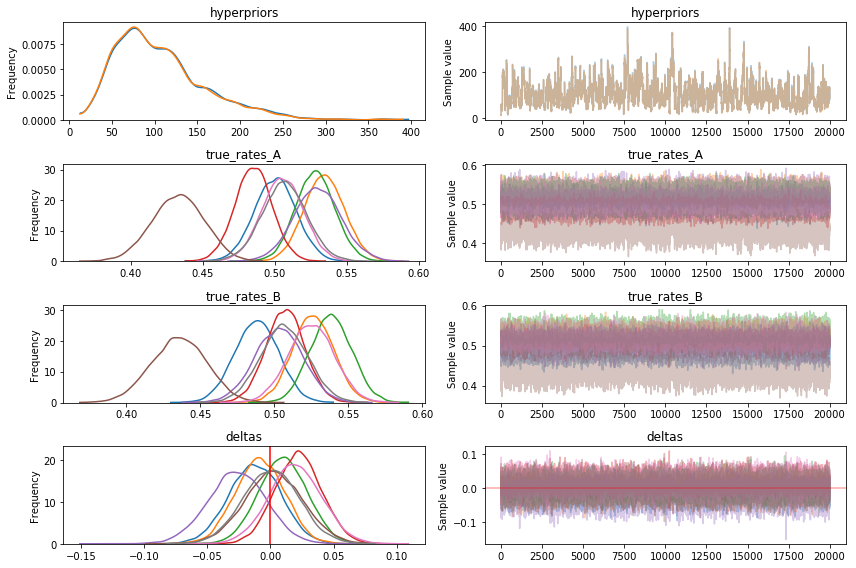

In [4]:
_ = pm.traceplot(trace, lines={'deltas':0})